参考：https://qiita.com/ku_a_i/items/74241c84cda8c7327277

In [36]:
#モジュールの準備
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn 
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import shap

In [15]:
#datasetの確認
data = load_boston()
data

{'data': array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
         4.9800e+00],
        [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
         9.1400e+00],
        [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
         4.0300e+00],
        ...,
        [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
         5.6400e+00],
        [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
         6.4800e+00],
        [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
         7.8800e+00]]),
 'target': array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9, 15. ,
        18.9, 21.7, 20.4, 18.2, 19.9, 23.1, 17.5, 20.2, 18.2, 13.6, 19.6,
        15.2, 14.5, 15.6, 13.9, 16.6, 14.8, 18.4, 21. , 12.7, 14.5, 13.2,
        13.1, 13.5, 18.9, 20. , 21. , 24.7, 30.8, 34.9, 26.6, 25.3, 24.7,
        21.2, 19.3, 20. , 16.6, 14.4, 19.4, 19.7, 20.5, 25. , 23.4, 18.9,
        35.4, 24.7, 3

In [18]:
#dataset内のdata,target,feature_nameを使用する
df = pd.DataFrame(data.data, columns=data.feature_names)
df["y"] = data.target

In [19]:
#データの確認
df.shape

(506, 14)

In [24]:
#欠損値の確認
df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
y          0
dtype: int64

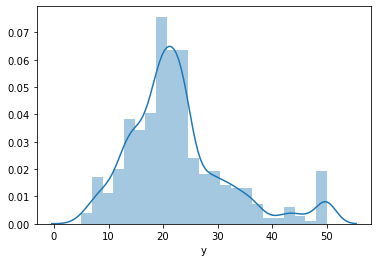

In [35]:
#yの値を可視化
sns.distplot(df["y"])

In [27]:
#データセット分割
X_train, X_test, y_train, y_test = train_test_split(df.drop("y",axis=1),df["y"],test_size=0.2,random_state=0)

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


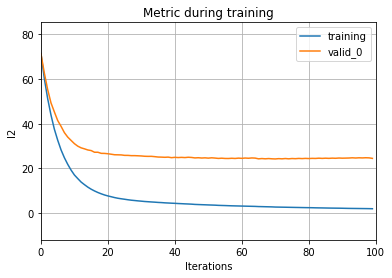

In [37]:
#モデルを定義
model = lgb.LGBMRegressor(random_state = 0)

model.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)], verbose=-1)

# 学習履歴の表示
lgb.plot_metric(model)

In [38]:
#予測結果
pred = model.predict(X_test)
#rmse
np.sqrt(mean_squared_error(y_test, pred))

4.949615816073845

家賃は２０を中心とした正規分布に近い形となっている。
また、データ数が少ないためモデルはlightgbmではなく決定木などのシンプルな方が良さそうだが、今回は予測精度を高めることが目的ではないため良しとする。また、予測誤差が約5と精度は高くないがこちらも上記理由により一旦スルー

In [39]:
#jupyter上で使用できるようにするためのおまじない
shap.initjs()

In [50]:
X = df.drop("y",axis=1)

#決定木モデル解釈
explainer = shap.TreeExplainer(model, X)
#shap値の計算
shap_values = explainer.shap_values(X)

print(explainer.expected_value)
print(shap_values)

22.34339742343489
[[-0.51774296 -0.01153019  0.33421684 ...  0.55969692  0.19723828
   3.54941528]
 [-0.49942848  0.0790605  -0.58048652 ...  0.17157906  0.19332193
   0.78834371]
 [-0.27324773  0.02602113 -0.27655881 ... -0.12655567  0.07044378
  10.14884671]
 ...
 [ 0.12196479  0.0403648  -0.3961389  ... -1.32901094  0.1238309
   1.77017096]
 [ 0.25025669  0.0438741  -0.50921363 ... -1.39790319  0.01196027
   2.2034594 ]
 [-0.17385319  0.05086766 -0.18621758 ... -0.94484652  0.1599732
   1.60128424]]


ここまで来れば後は知りたい内容に合致したコードをドキュメントから引用すれば簡単に可視化が可能
URL:https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20LightGBM.html?highlight=treeexplainer

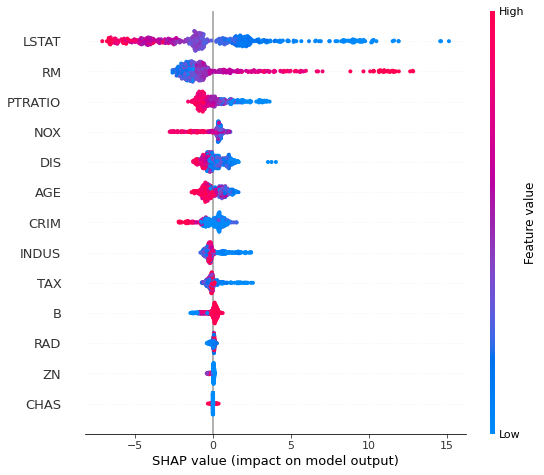

In [52]:
#各特徴量の影響度を可視化
shap.summary_plot(shap_values, X) 

赤い点は説明変数の値が大きい場合を示し、青い点は小さい値を示す
これを見るとLSTATが一番影響度が高く、値が大きいほど予測結果は低く予測される。
RM(1住戸辺りの平均部屋数)は大きいほど予測結果も高くなっている

In [54]:
#試しに一人のぞいてみる
shap.force_plot(explainer.expected_value, shap_values[1,:], X.iloc[1,:])

予測結果を上げている要因が赤色、下げている要因は青色で表される
BやNOX、LSTATが予測結果を上げており、AGEやINDUSなどが下げている
あくまで1つのデータを見ただけのため、全体の傾向とは言えないので注意が必要

In [55]:
#前データを使用して結果を見てみる
shap.force_plot(base_value=explainer.expected_value, shap_values=shap_values, features=X)

横軸がLSTATの値、f(x)が予測値の値となる
LSTATは値が高くなるほど予測結果が低くなることがわかる
AGEもLSTATほどではないが高くなるほど予測結果が低くなっている

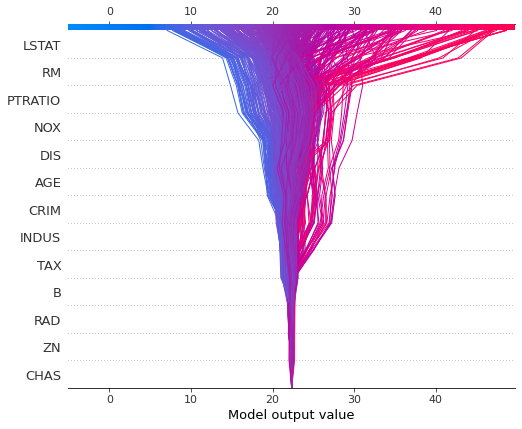

In [57]:
#予測結果算出までの過程を可視化
shap.decision_plot(explainer.expected_value, shap_values,X)

下段に記載されているCHAS,ZN,RADはほとんど予測に寄与していないことがわかる。
Bで若干数が下振れ、上振れに変化し、以降の特徴量は予測に寄与していることが伺える。
予測精度が非常に高く予測される人はRMで急激に増加していることがわかる。
下振れはLSTATの影響が大きく、徐々に減少していき最後にガクッと下がっていることが伺える。

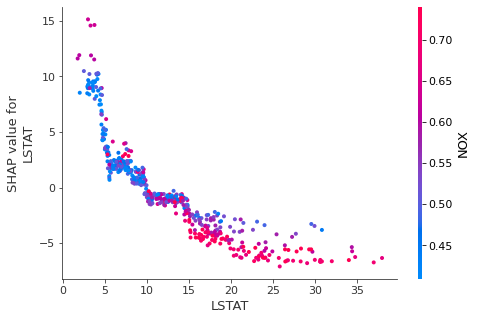

In [58]:
shap.dependence_plot("LSTAT", shap_values, X)

縦軸がshap値、横軸がLSTATの値となっている。
LSTATが高いほどshap値は低くなっていることがわかる。
色は交互作用が一番はっきりと表れる変数が自動で選択される。
NOXが大きいほど赤くなっており、同じLSTATの場合、NOXが大きいほどshap値が小さくなることがわかる。

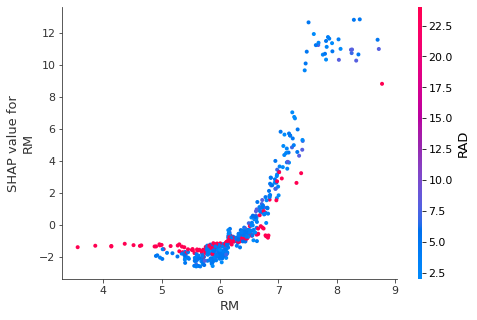

In [60]:
shap.dependence_plot("RM", shap_values, X)

部屋の数は６までは予測に寄与していないが６を超えると急激に影響度が大きくなっている

In [ ]:
・RMなど予測に効きそうなことは直感的にわかるが、実際に何部屋から予測に寄与するかなどをfeature_importances
から読み取ることは難しいためshapを使用することで、各特徴量の値の変化による予測への寄与度を簡単に可視化出来ることは予測に寄与する特徴量を探索していく上で効率的になると感じた。
